In [2]:
import json
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

In [3]:
ground_truth_path = "F:/MASC/Jali_sing/validation/faceware session 2022 Apr 1st/julie_takes/rap_jali_faceware.json"
jali_sing_path = "F:/MASC/Jali_sing/validation/faceware session 2022 Apr 1st/julie_takes/rap_jali.json"

In [4]:
with open(ground_truth_path) as f:
    ground_truth = json.load(f)
with open(jali_sing_path) as f:
    jali_sing = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'F:/MASC/Jali_sing/validation/faceware session 2022 Apr 1st/julie_takes/rap_jali_faceware.json'

# create a difference over time video

In [7]:
def display_landmark(ground_truth, jali_sing, fps):
    fig, ax = plt.subplots()
    fig.set_tight_layout(True)
    def update(i):
        label = 'timestep {0}'.format(i)
        # Update the line and the axes (with a new xlabel). Return a tuple of
        # "artists" that have to be redrawn for this frame.
        print(i)
        fig.clf()
        true_vertex_pos_i = ground_truth[str(i)]
        true_vertex_pos_i = np.array(true_vertex_pos_i)

        jali_sing_vertex_pos_i = jali_sing[str(i)]
        jali_sing_vertex_pos_i = np.array(jali_sing_vertex_pos_i)
        plt.scatter(true_vertex_pos_i[:, 0], true_vertex_pos_i[:, 1], c=np.linalg.norm(true_vertex_pos_i - jali_sing_vertex_pos_i, axis=1))
        return ax
    anim = FuncAnimation(fig, update, frames=np.arange(0, min(len(ground_truth.keys()), len(jali_sing.keys()))), interval=fps)
    f = r"F:/MASC/Jali_sing/validation/faceware session 2022 Apr 1st/julie_takes/rap_jali_comparison.avi" 
    writervideo = animation.FFMpegWriter(fps=25)
    anim.save(f, writer=writervideo)
# display_landmark(ground_truth, jali_sing, 24)

# create a cumulative difference image

In [6]:
true_vertex_pos_0 = ground_truth[str(0)]
true_vertex_pos_0 = np.array(true_vertex_pos_0)
cumulative_difference = np.zeros(true_vertex_pos_0.shape[0],)
diff = []
for i in np.arange(0, min(len(ground_truth.keys()), len(jali_sing.keys()))):
    true_vertex_pos_i = ground_truth[str(i)]
    true_vertex_pos_i = np.array(true_vertex_pos_i)
    jali_sing_vertex_pos_i = jali_sing[str(i)]
    jali_sing_vertex_pos_i = np.array(jali_sing_vertex_pos_i)
    diff.append(np.linalg.norm(true_vertex_pos_i - jali_sing_vertex_pos_i, axis=1).mean())

plt.plot(diff)

NameError: name 'ground_truth' is not defined

# 2. Compare faceware landmark speed over during consonants

## 2.a Helper functions

In [8]:
import xml.etree.ElementTree as ET
import numpy as np
from matplotlib import pyplot as plt

class faceWareLandmarkObject():

    fps = 0
    start = 0
    end = 0
    total_frame = 0
    num_landmarks = 52
    data = None
    data_dict = {"mouth":list(range(25, 51)), "eye":list(range(13, 25)), "nose":[0, 1, 2], "brow":list(range(3, 13))}
    def __init__(self, fileName):
        # [metadata/frames][frame_i][0][mouth/eyes/brows][0][landmark_i]
        mytree = ET.parse(fileName)
        myroot = mytree.getroot()
        self.start = myroot[0][0].attrib["rangeStart"]
        self.end = myroot[0][0].attrib["rangeEnd"]
        self.fps = int(np.ceil(float(myroot[0][0].attrib["frameRate"])))
        self.total_frame = faceWareLandmarkObject.stringToFrame(self.end, self.fps)
        i = 3
        self.data = []
        for t in range(0, self.total_frame):
            frameT = np.zeros((52, 3))
            for i in range(0, 13):# nose and brow
                # [metadata/frames][frame_i][0][mouth/eyes/brows][0][landmark_i][textCoord2D/position3D]
                u_i = float(myroot[1][t][0][2][0][i][0].attrib["u"])
                v_i = -float(myroot[1][t][0][2][0][i][0].attrib["v"])
                frameT[i, 0] = u_i
                frameT[i, 1] = v_i
            for i in range(3, 15):  # nose and brow
                # [metadata/frames][frame_i][0][mouth/eyes/brows][0][landmark_i][textCoord2D/position3D]
                u_i = float(myroot[1][t][0][1][0][i][0].attrib["u"])
                v_i = -float(myroot[1][t][0][1][0][i][0].attrib["v"])
                frameT[i+10, 0] = u_i
                frameT[i+10, 1] = v_i
            for i in range(0, 27):  # nose and brow
                # [metadata/frames][frame_i][0][mouth/eyes/brows][0][landmark_i][textCoord2D/position3D]
                u_i = float(myroot[1][t][0][0][0][i][0].attrib["u"])
                v_i = -float(myroot[1][t][0][0][0][i][0].attrib["v"])
                frameT[25+i, 0] = u_i
                frameT[25+i, 1] = v_i
            self.data.append(np.expand_dims(frameT, 0))
        self.data = np.concatenate(self.data, axis=0)
#         print(self.data.shape)
    @staticmethod
    def stringToFrame(strFrameVal, fps):
        minutes = strFrameVal.split(":")[1]
        sec = strFrameVal.split(":")[2]
        frames = strFrameVal.split(":")[3]
        out = (int(minutes) * 60 + int(sec)) * fps + int(frames) + 1
        return out
    def getBrows(self):
        leftBrow = self.data[:, 8:13, :]
        rightBrow = self.data[:, 3:8, :]
        return [leftBrow, rightBrow]
    def getNose(self):
        nose = self.data[:, 0:3, :]
        return nose
    def getEyes(self):
        rightEye = self.data[:,13:17]
        leftEye = self.data[:, 17:21]
        return [rightEye, leftEye]
    def getMouth(self):
        innerLip = self.data[:, 39:52]
        outerLip = self.data[:, 25:39]
        return [innerLip, outerLip]
def get_average_velocity(lm, dt):
    # lm.shape = [time, lm, 3]
    pos = lm[:, :, 0:2]
    pos_t = np.zeros((pos.shape[0]+1, pos.shape[1], pos.shape[2]))
    pos_tm1 = np.zeros((pos.shape[0]+1, pos.shape[1], pos.shape[2]))
    pos_t[1:] = pos
    pos_tm1[:-1] = pos
    vel = (pos_t - pos_tm1)/dt
    vel = np.square(vel).sum(axis=2).mean(axis=1)
    vel[0] = 0
    return vel[:-2]

import textgrids
def select_only_consonant(praat_file_location, landmark_array, fps, delta=0.1):
    dt = 1.0 / fps
    grid = textgrids.TextGrid(praat_file_location)
    phoneme_list = []
    phoneme_intervals = []
    word_list = []
    word_intervals = []
    for i in range(0, len(grid["phones"])):
        phoneme_list.append(grid["phones"][i].text)
        phoneme_intervals.append([grid["phones"][i].xmin, grid["phones"][i].xmax])
    try:
        for i in range(0, len(grid["words"])):
            word_list.append(grid["words"][i].text)
            word_intervals.append([grid["words"][i].xmin, grid["words"][i].xmax])
    except:
        pass
    
    for k in range(len(phoneme_list)):
        if phoneme_list[k] != ">":
            start_time = phoneme_intervals[k][0]
            break
    for k in range(len(phoneme_list)):
        phoneme_intervals[k][0] = phoneme_intervals[k][0] - start_time
        phoneme_intervals[k][1] = phoneme_intervals[k][1] - start_time
    
    cmd_dict = CMU_phonemes_dicts()
    landmark_array_x = np.arange(0, landmark_array.shape[0])/fps
    lm_interp = interp1d(landmark_array_x, landmark_array)
    out = []
    for i in range(0, len(phoneme_intervals)):
        interval = phoneme_intervals[i]
        phone = phoneme_list[i]
        if phone in cmd_dict.consonants:
            try:
                ts = np.arange(max(interval[0]-delta, landmark_array_x[0]), min(interval[1]+delta, landmark_array_x[-1]), dt)
            except:
                ts = np.arange(max(interval[0], landmark_array_x[0]), min(interval[1], landmark_array_x), dt)
            out.append([ts, lm_interp(ts)])
    return out
def select_only_vowels(praat_file_location, landmark_array, fps, delta=0):
    dt = 1.0 / fps
    grid = textgrids.TextGrid(praat_file_location)
    phoneme_list = []
    phoneme_intervals = []
    word_list = []
    word_intervals = []
    for i in range(0, len(grid["phones"])):
        phoneme_list.append(grid["phones"][i].text)
        phoneme_intervals.append([grid["phones"][i].xmin, grid["phones"][i].xmax])
    try:
        for i in range(0, len(grid["words"])):
            word_list.append(grid["words"][i].text)
            word_intervals.append([grid["words"][i].xmin, grid["words"][i].xmax])
    except:
        pass
    
    for k in range(len(phoneme_list)):
        if phoneme_list[k] != ">":
            start_time = phoneme_intervals[k][0]
            break
    for k in range(len(phoneme_list)):
        phoneme_intervals[k][0] = phoneme_intervals[k][0] - start_time
        phoneme_intervals[k][1] = phoneme_intervals[k][1] - start_time
    
    cmd_dict = CMU_phonemes_dicts()
    landmark_array_x = np.arange(0, landmark_array.shape[0])/fps
    lm_interp = interp1d(landmark_array_x, landmark_array)
    out = []
    for i in range(0, len(phoneme_intervals)):
        interval = phoneme_intervals[i]
        phone = phoneme_list[i]
        if phone in cmd_dict.vowels:
            try:
                ts = np.arange(max(interval[0]-delta, landmark_array_x[0]), min(interval[1]+delta, landmark_array_x[-1]), dt)
            except:
                ts = np.arange(max(interval[0], landmark_array_x[0]), min(interval[1], landmark_array_x), dt)
            out.append([ts, lm_interp(ts)])
    return out

# 2.1a Raw Yannis Ma comparison

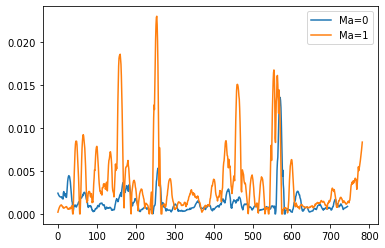

In [143]:
fps = 30.0
dt = 1/fps


fileName = "F:\\MASC\\Jali_sing\\Revision\\validation\\faceware session Yannis\\Oh Canada\\landmark_comparison\\Ma0.xml"
lm_Ma0 = faceWareLandmarkObject(fileName)

fileName = "F:\\MASC\\Jali_sing\\Revision\\validation\\faceware session Yannis\\Oh Canada\\landmark_comparison\\Ma1.xml"
lm_Ma1 = faceWareLandmarkObject(fileName)


mouth_Ma0 = lm_Ma0.getMouth()[0]
velocity_Ma0 = savgol_filter(get_average_velocity(mouth_Ma0, dt), 19, 2)
velocity_Ma0 = np.where(velocity_Ma0>0, velocity_Ma0, 0)
mouth_Ma1 = lm_Ma1.getMouth()[0]
velocity_Ma1 = savgol_filter(get_average_velocity(mouth_Ma1, dt), 19, 2)
velocity_Ma1 = np.where(velocity_Ma1>0, velocity_Ma1, 0)

plt.plot(velocity_Ma0, label="Ma=0")
plt.plot(velocity_Ma1, label="Ma=1")
plt.legend()
plt.show()

# 2.1b Raw Yannis Ps comparison

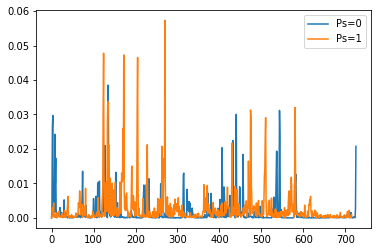

In [189]:
fileName = "F:\\MASC\\Jali_sing\\Revision\\validation\\faceware session Yannis\\Oh Canada\\landmark_comparison\\Ps0.xml"
lm_Ps0 = faceWareLandmarkObject(fileName)

fileName = "F:\\MASC\\Jali_sing\\Revision\\validation\\faceware session Yannis\\Oh Canada\\landmark_comparison\\Ps1.xml"
lm_Ps1 = faceWareLandmarkObject(fileName)


mouth_Ps0 = lm_Ps0.getMouth()[0]
velocity_Ps0 = savgol_filter(get_average_velocity(mouth_Ps0, dt), 21, 2)
velocity_Ps0 = get_average_velocity(mouth_Ps0, dt)
velocity_Ps0 = np.where(velocity_Ps0>0, velocity_Ps0, 0)

mouth_Ps1 = lm_Ps1.getMouth()[0]
velocity_Ps1 = savgol_filter(get_average_velocity(mouth_Ps1, dt), 21, 2)
velocity_Ps1 = get_average_velocity(mouth_Ps1, dt)

velocity_Ps1 = np.where(velocity_Ps1>0, velocity_Ps1, 0)

plt.plot(velocity_Ps0, label="Ps=0")
plt.plot(velocity_Ps1, label="Ps=1")
plt.legend()
plt.show()

# 2.2 Oh Canada Yannis comparison

## 2.2a automatically generate raw alignment

In [190]:
# generate raw word alignment

from util.SongDataStructure import Minimal_song_data_structure, CMU_phonemes_dicts
from util.ioUtil import get_wav_from_video
datapath = "F:\\MASC\\Jali_sing\\Revision\\validation\\faceware session Yannis\\Oh Canada\\jali_sing_stuff"
files = ["Ma0_facecam", "Ma1_facecam", "Ps0_facecam", "Ps1_facecam"]
arrs = [velocity_Ma0, velocity_Ma1, velocity_Ps0, velocity_Ps1]
# for item in files:
#     get_wav_from_video(item+".mp4", datapath)
#     song = Minimal_song_data_structure(datapath+"\\"+item+".wav", datapath+"\\"+item+".txt", )
#     song.compute_self_phoneme_alignment()
#     song.write_textgrid(datapath, item)

## 2.2b after manually fixing alignment

In [191]:
i = 0
consonant_out = []
consonant_out.append(select_only_consonant(datapath+"\\"+files[0]+".TextGrid", arrs[0], fps))
consonant_out.append(select_only_consonant(datapath+"\\"+files[1]+".TextGrid", arrs[1], fps))
consonant_out.append(select_only_consonant(datapath+"\\"+files[2]+".TextGrid", arrs[2], fps))
consonant_out.append(select_only_consonant(datapath+"\\"+files[3]+".TextGrid", arrs[3], fps))

vowel_out = []
vowel_out.append(select_only_vowels(datapath+"\\"+files[0]+".TextGrid", arrs[0], fps))
vowel_out.append(select_only_vowels(datapath+"\\"+files[1]+".TextGrid", arrs[1], fps))
vowel_out.append(select_only_vowels(datapath+"\\"+files[2]+".TextGrid", arrs[2], fps))
vowel_out.append(select_only_vowels(datapath+"\\"+files[3]+".TextGrid", arrs[3], fps))

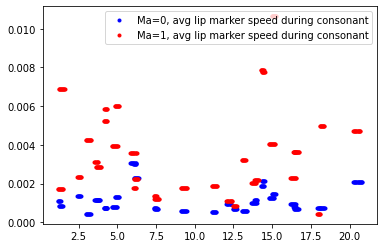

In [192]:
for i in range(len(consonant_out[0])):
    item = consonant_out[0][i]
    if i == 0:
        plt.plot(item[0], item[1].mean() * np.ones(item[0].shape), "bo",  markersize=3, label="Ma=0, avg lip marker speed during consonant")
    else:
        plt.plot(item[0], item[1].mean() * np.ones(item[0].shape), "bo",  markersize=3)
        
        
for i in range(len(consonant_out[1])):
    item = consonant_out[1][i]
    comparison_start_i = consonant_out[0][i][0][0]
    item_start_i = item[0][0]
    diff = item_start_i - comparison_start_i
    if i == 0:
        plt.plot(item[0]-diff, item[1].mean() * np.ones(item[0].shape), "ro",  markersize=3, label="Ma=1, avg lip marker speed during consonant")
    else:
        plt.plot(item[0]-diff, item[1].mean() * np.ones(item[0].shape), "ro", markersize=3)        
plt.legend()

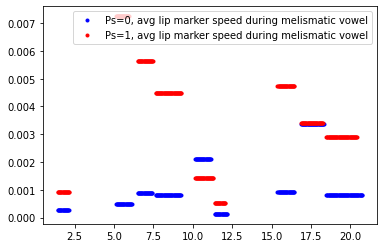

In [205]:
tripped = 0
for i in range(1, len(vowel_out[2])):
    item = vowel_out[2][i]
    if (item[0][-1] - item[0][0] >= 0.5):
        if tripped == 0:
            plt.plot(item[0], item[1].mean() * np.ones(item[0].shape), "bo", label="Ps=0, avg lip marker speed during melismatic vowel",markersize=3)
            tripped = 1
        else:
            plt.plot(item[0], item[1].mean() * np.ones(item[0].shape), "bo", markersize=3)

tripped = 0
for i in range(1, len(vowel_out[3])):
    item = vowel_out[3][i]
    comparison_start_i = vowel_out[2][i][0][0]
    item_start_i = item[0][0]
    diff = item_start_i - comparison_start_i
    if (item[0][-1] - item[0][0] >= 0.5):
        if tripped == 0:
            plt.plot(item[0]-diff, item[1].mean() * np.ones(item[0].shape), "ro", label="Ps=1, avg lip marker speed during melismatic vowel", markersize=3)
            tripped = 1
        else:
            plt.plot(item[0]-diff, item[1].mean() * np.ones(item[0].shape), "ro", markersize=3)
        
plt.legend()
    

# 3.0 Martin Ma comparison

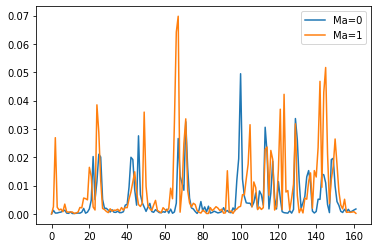

In [230]:
fps = 30.0
dt = 1/fps


fileName = "F:\\MASC\\Jali_sing\\Revision\\validation\\faceware session Martin\\stress and strain\\landmark_comparison\\Ma0.xml"
lm_Ma0 = faceWareLandmarkObject(fileName)

fileName = "F:\\MASC\\Jali_sing\\Revision\\validation\\faceware session Martin\\stress and strain\\landmark_comparison\\Ma1.xml"
lm_Ma1 = faceWareLandmarkObject(fileName)


mouth_Ma0 = lm_Ma0.getMouth()[0]
velocity_Ma0 = get_average_velocity(mouth_Ma0, dt)
velocity_Ma0 = np.where(velocity_Ma0>0, velocity_Ma0, 0)
mouth_Ma1 = lm_Ma1.getMouth()[0]
velocity_Ma1 = get_average_velocity(mouth_Ma1, dt)
velocity_Ma1 = np.where(velocity_Ma1>0, velocity_Ma1, 0)

plt.plot(velocity_Ma0, label="Ma=0")
plt.plot(velocity_Ma1, label="Ma=1")
plt.legend()
plt.show()

In [212]:
# generate raw word alignment

from util.SongDataStructure import Minimal_song_data_structure, CMU_phonemes_dicts
from util.ioUtil import get_wav_from_video
datapath = "F:\\MASC\\Jali_sing\\Revision\\validation\\faceware session Martin\\stress and strain\\jali_sing_stuff"
files = ["Ma0_facecam", "Ma1_facecam"]
arrs = [velocity_Ma0, velocity_Ma1, velocity_Ps0, velocity_Ps1]
# for item in files:
#     get_wav_from_video(item+".mp4", datapath)
#     song = Minimal_song_data_structure(datapath+"\\"+item+".wav", datapath+"\\"+item+".txt", )
#     song.compute_self_phoneme_alignment()
#     song.write_textgrid(datapath, item)

MoviePy - Writing audio in F:\MASC\Jali_sing\Revision\validation\faceware session Martin\stress and strain\jali_sing_stuff\Ma0_facecam.wav


MoviePy - Done.


['>', 'S', 'T', 'R', 'EH', 'S', '>', 'AH', 'N', 'D', '>', 'S', 'T', 'R', 'EY', 'N', '>', 'L', 'AY', 'K', '>', 'AE', 'N', '>', 'AH', 'B', 'JH', 'EH', 'K', 'SH', 'AH', 'N', '>', 'S', 'AH', 'S', 'T', 'EY', 'N', 'D', '>', 'OW', 'V', 'ER', '>', 'R', 'UW', 'L', 'D', '>', 'B', 'AY', '>', 'F', 'UW', 'L', '>', 'HH', 'UW', '>', 'K', 'AH', 'M', 'P', 'L', 'EY', 'N']
[[0.0191875, 0.5471875], [0.5471875, 0.7391875], [0.7391875, 0.8031875], [0.8031875, 0.9151875], [0.9151875, 0.9791875], [0.9791875, 1.1231875], [1.1231875, 1.1391875], [1.1391875, 1.1711874999999998], [1.1711874999999998, 1.2191874999999999], [1.2191874999999999, 1.2351874999999999], [1.2351874999999999, 1.2511875], [1.2511875, 1.3951874999999998], [1.3951874999999998, 1.4911874999999999], [1.4911874999999999, 1.5711875], [1.5711875, 1.9871874999999999], [1.9871874999999999, 2.0031875], [2.0031875, 2.0511875], [2.0511875, 2.0831875], [2.0831875, 2.1471875000000002], [2.1471875000000002, 2.1631875000000003], [2.1631875000000003, 2.1791

MoviePy - Done.


['>', 'S', 'T', 'R', 'EH', 'S', '>', 'AH', 'N', 'D', '>', 'S', 'T', 'R', 'EY', 'N', '>', 'L', 'AY', 'K', '>', 'AE', 'N', '>', 'AH', 'B', 'JH', 'EH', 'K', 'SH', 'AH', 'N', '>', 'S', 'AH', 'S', 'T', 'EY', 'N', 'D', '>', 'OW', 'V', 'ER', '>', 'R', 'UW', 'L', 'D', '>', 'B', 'AY', '>', 'F', 'UW', 'L', '>', 'HH', 'UW', '>', 'K', 'AH', 'M', 'P', 'L', 'EY', 'N']
[[0.0279375, 0.5719375], [0.5719375, 0.7319374999999999], [0.7319374999999999, 0.7959375], [0.7959375, 0.8759374999999999], [0.8759374999999999, 1.0359375], [1.0359375, 1.1319375], [1.1319375, 1.2119375], [1.2119375, 1.2599375], [1.2599375, 1.2919375], [1.2919375, 1.3079375], [1.3079375, 1.3239375], [1.3239375, 1.4839375], [1.4839375, 1.5799375], [1.5799375, 1.6599374999999998], [1.6599374999999998, 1.8359375], [1.8359375, 1.8679375], [1.8679375, 1.8839375], [1.8839375, 1.9319374999999999], [1.9319374999999999, 1.9959375], [1.9959375, 2.0119375], [2.0119375, 2.0279375], [2.0279375, 2.0599375], [2.0599375, 2.0919375000000002], [2.091937

In [228]:
i = 0
consonant_out = []
consonant_out.append(select_only_consonant(datapath+"\\"+files[0]+".TextGrid", arrs[0], fps, delta=0))
consonant_out.append(select_only_consonant(datapath+"\\"+files[1]+".TextGrid", arrs[1], fps, delta=0))

vowel_out = []
vowel_out.append(select_only_vowels(datapath+"\\"+files[0]+".TextGrid", arrs[0], fps))
vowel_out.append(select_only_vowels(datapath+"\\"+files[1]+".TextGrid", arrs[1], fps))

36


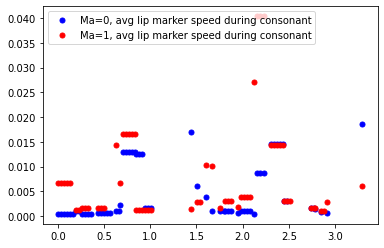

In [231]:
print(len(consonant_out[0]))

for i in range(len(consonant_out[0])-10):
    item = consonant_out[0][i]
    if i == 0:
        plt.plot(item[0], item[1].mean() * np.ones(item[0].shape), "bo",  markersize=5, label="Ma=0, avg lip marker speed during consonant")
    else:
        plt.plot(item[0], item[1].mean() * np.ones(item[0].shape), "bo",  markersize=5)
        
        
for i in range(len(consonant_out[1])-10):
    item = consonant_out[1][i]
    comparison_start_i = consonant_out[0][i][0][0]
    item_start_i = item[0][0]
    diff = item_start_i - comparison_start_i
    if i == 0:
        plt.plot(item[0]-diff, item[1].mean() * np.ones(item[0].shape), "ro",  markersize=5, label="Ma=1, avg lip marker speed during consonant")
    else:
        plt.plot(item[0]-diff, item[1].mean() * np.ones(item[0].shape), "ro", markersize=5)        
plt.legend(loc='upper left')

# 4.0 Generate Lip Animations for Teaser Animation 

In [22]:
# generate raw word alignment

from util.SongDataStructure import Minimal_song_data_structure, CMU_phonemes_dicts
from util.ioUtil import get_wav_from_video
datapath = "F:\\MASC\\Jali_sing\\Revision\\Lip Sync live performances\\"
file_paths = ["reference_vocals", "reference_vocals", "reference_vocals", "reference_vocals"]
folder_paths = [datapath+"Mans_World\\", datapath+"rolling in the deep\\", datapath+"summum bolum\\", datapath+"tom sawyer\\"]
for i in range(0, 4):
#     get_wav_from_video(file_paths[i], folder_paths[i])
#     song = Minimal_song_data_structure(folder_paths[i]+file_paths[i]+".wav", folder_paths[i]+file_paths[i]+".txt", )
#     song.compute_self_phoneme_alignment()
#     song.write_textgrid(folder_paths[i], file_paths[i])

['>', 'DH', 'IH', 'S', '>', 'IH', 'Z', '>', 'AH', '>', 'M', 'AE', 'N', 'Z', '>', 'W', 'ER', 'L', 'D', '>', 'AA', '>', 'B', 'AH', 'T', '>', 'IH', 'T', '>', 'W', 'UH', 'D', 'AH', 'N', 'T', '>', 'B', 'IY', '>', 'N', 'AH', 'TH', 'IH', 'NG', '>', 'N', 'AH', 'TH', 'IH', 'NG', '>', 'N', 'AA', 'T', '>', 'D', 'UW', 'D']
[[0.0006875, 0.0166875], [0.0166875, 0.5286875], [0.5286875, 2.7686875], [2.7686875, 3.0086875], [3.0086875, 3.0246875], [3.0246875, 3.3446875], [3.3446875, 3.5366875], [3.5366875, 8.0966875], [8.0966875, 8.4486875], [8.4486875, 8.4646875], [8.4646875, 8.5446875], [8.5446875, 8.8806875], [8.8806875, 8.9126875], [8.9126875, 8.9286875], [8.9286875, 8.9446875], [8.9446875, 8.9766875], [8.9766875, 10.3366875], [10.3366875, 10.3686875], [10.3686875, 10.3846875], [10.3846875, 10.4966875], [10.4966875, 10.5126875], [10.5126875, 10.5286875], [10.5286875, 10.6886875], [10.6886875, 10.8646875], [10.8646875, 10.9126875], [10.9126875, 10.9286875], [10.9286875, 11.200687499999999], [11.20068

['>', 'DH', 'OW', '>', 'HH', 'IH', 'Z', '>', 'M', 'AY', 'N', 'D', '>', 'IH', 'Z', '>', 'N', 'AA', 'T', '>', 'F', 'AO', 'R', '>', 'R', 'EH', 'N', 'T', '>', 'D', 'OW', 'N', 'T', '>', 'P', 'UH', 'T', '>', 'HH', 'IH', 'M', '>', 'D', 'AW', 'N', '>', 'AE', 'Z', '>', 'EH', 'R', 'AH', 'G', 'AH', 'N', 'T', '>', 'HH', 'IH', 'Z', '>', 'R', 'IH', 'Z', 'ER', 'V', '>', 'AH', '>', 'K', 'W', 'AY', 'AH', 'T', '>', 'D', 'IH', 'F', 'EH', 'N', 'S', '>', 'R', 'AY', 'D', 'IH', 'NG', '>', 'AW', 'T', '>', 'DH', 'AH', '>', 'D', 'EY', 'Z', '>', 'IH', 'V', 'EH', 'N', 'T', 'S', '>', 'DH', 'AH', '>', 'R', 'IH', 'V', 'ER']
[[0.21975, 0.23575000000000002], [0.23575000000000002, 0.31575], [0.31575, 0.49175], [0.49175, 0.5077499999999999], [0.5077499999999999, 0.53975], [0.53975, 0.57175], [0.57175, 0.58775], [0.58775, 0.60375], [0.60375, 0.6837500000000001], [0.6837500000000001, 0.89175], [0.89175, 0.97175], [0.97175, 0.98775], [0.98775, 1.0037500000000001], [1.0037500000000001, 1.09975], [1.09975, 1.11575], [1.11575